In [94]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
# Read in the data and reduce it to only city demographics
cali_data = pd.read_csv("data/combined_shooting_census.csv")
#cali_data.rename(columns={"Unnamed: 0":"city_id"}, inplace=True)

# Being lazy and just filling in NAs for race columnswith the mean of the data
race_data = cali_data[['share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic']]
race_data.fillna(race_data.mean(), inplace=True)
race_data.isna().sum()

/Users/savvy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


share_white              0
share_black              0
share_native_american    0
share_asian              0
share_hispanic           0
dtype: int64

In [96]:
# Simplify the race information
majority = []
# 0 = black
# 1 = native american
# 2 = asian
# 3 = hispanic
# 4 = white
for index, row in race_data.iterrows():
    if (row['share_black'] >= 50):
        majority.append(0)
    elif (row['share_native_american'] >= 50):
        majority.append(1)
    elif (row['share_asian'] >= 50):
        majority.append(2)
    elif (row['share_hispanic'] >= 50):
        majority.append(3)
    else:
        majority.append(4)

cities = cali_data[['Median Income',
       'percent_completed_hs', 'poverty_rate']]
cities["majority"] = majority
cities.head()

<ipython-input-96-0d106343562b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities["majority"] = majority


Median Income  percent_completed_hs  poverty_rate  majority
0         37072                  80.1          28.6         4
1         65765                  88.1          14.9         4
2         45947                  87.5          17.3         4
3         81294                  87.0          13.2         4
4         47791                  76.3          16.6         4

In [97]:
# Being lazy and just filling in NAs with the median of the data
cities["Median Income"].replace(["(X)","-"],"", inplace=True)
cities["Median Income"] = pd.to_numeric(cities["Median Income"])
cities.fillna(cities.median(), inplace=True)
cities.isna().sum()

/Users/savvy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-97-35f4b8984e3a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities["Median Income"] = pd.to_numeric(cities["Median Income"])
/Users/savvy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

Median Income           0
percent_completed_hs    0
poverty_rate            0
majority                0
dtype: int64

In [98]:
# Ok let's get into the ML part...
data = np.array(cities)
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

KMeans(n_clusters=3)

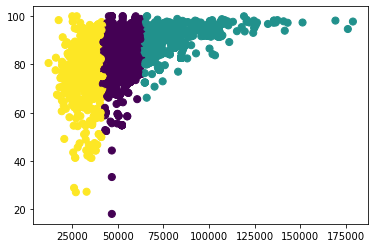

In [99]:
prediction = kmeans.predict(data)

# Just comparing two colunns of data here
plt.scatter(data[:, 0], data[:, 1], c=prediction, s=50, cmap='viridis')
plt.show()

In [100]:
# To look at all four columns, need to use PCA
pca = PCA(n_components=2)
output = pca.fit_transform(data)
output_df = pd.DataFrame(output)
output_df.columns = ["x","y"]
output_df["prediction"] = prediction

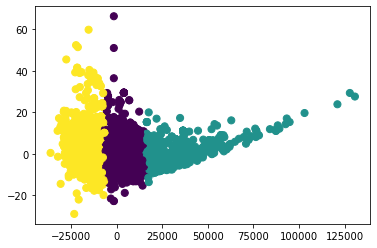

In [101]:
plt.scatter(output_df["x"], output_df["y"], c=output_df["prediction"], s=50, cmap='viridis')
plt.show()

### City data was too continuous...let's throw more columns at it!

In [102]:
# Get more attributes/features/columns to look at
moreAtts = cali_data[['manner_of_death', 'armed', 'age',
       'gender', 'race', 'signs_of_mental_illness',
       'threat_level', 'flee', 'body_camera']]
allAtts = pd.concat([moreAtts,cities], axis=1)
allAtts.isna().sum()

manner_of_death              0
armed                      208
age                        271
gender                       1
race                       602
signs_of_mental_illness      0
threat_level                 0
flee                       348
body_camera                  0
Median Income                0
percent_completed_hs         0
poverty_rate                 0
majority                     0
dtype: int64

In [103]:
def cleanupData(df):
    # Take care of those NAs
    df["age"].fillna(df["age"].median(),inplace=True)
    df["armed"].fillna("undetermined",inplace=True)
    df["race"].fillna("O",inplace=True)
    df["flee"].fillna("Other",inplace=True)
    df.dropna(inplace=True)
    df.isna().sum()

    # Convert it all to numeric data (manner_of_death,armed,gender,race,threat_level,flee,body_camera)
    labelEncoder = LabelEncoder()
    labelEncoder.fit(df["manner_of_death"])
    df["manner_of_death"] = labelEncoder.transform(df["manner_of_death"])

    # Simplify armed into two categories
    # 0 - unarmed
    # 1 - armed
    # 2 - undetermined
    armed = []
    for index, row in df.iterrows():
        if (row['armed'] == "unarmed"):
            armed.append(0)
        elif (row['armed'] == "undetermined"):
            armed.append(2)
        else:
            armed.append(1)
    df.drop("armed",1)
    df["armed"] = armed

    # Now converting gender, race, mental illness, threat, flee, body_camera
    labelEncoder.fit(df["gender"])
    df["gender"] = labelEncoder.transform(df["gender"])
    labelEncoder.fit(df["race"])
    df["race"] = labelEncoder.transform(df["race"])
    labelEncoder.fit(df["signs_of_mental_illness"])
    df["signs_of_mental_illness"] = labelEncoder.transform(df["signs_of_mental_illness"])
    labelEncoder.fit(df["threat_level"])
    df["threat_level"] = labelEncoder.transform(df["threat_level"])
    labelEncoder.fit(df["flee"])
    df["flee"] = labelEncoder.transform(df["flee"])
    labelEncoder.fit(df["body_camera"])
    df["body_camera"] = labelEncoder.transform(df["body_camera"])

    return df
cleanupData(allAtts)
allAtts.dtypes

manner_of_death              int64
armed                        int64
age                        float64
gender                       int64
race                         int64
signs_of_mental_illness      int64
threat_level                 int64
flee                         int64
body_camera                  int64
Median Income              float64
percent_completed_hs       float64
poverty_rate               float64
majority                     int64
dtype: object

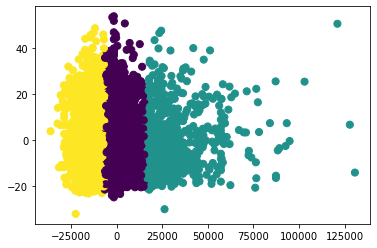

In [104]:
# Ok let's get into the ML part...
attData = np.array(allAtts)
kmeans = KMeans(n_clusters=3)
kmeans.fit(attData)

attPrediction = kmeans.predict(attData)
# Use PCA to plot it
pca = PCA(n_components=2)
attOut = pca.fit_transform(attData)
attOutput_df = pd.DataFrame(attOut)
attOutput_df.columns = ["x","y"]
attOutput_df["prediction"] = attPrediction

plt.scatter(attOutput_df["x"], attOutput_df["y"], c=attOutput_df["prediction"], s=50, cmap='viridis')
plt.show()

### Trying with aggregated data

In [106]:
aggCities = cali_data[['city','manner_of_death', 'armed', 'age',
       'gender', 'race', 'signs_of_mental_illness',
       'threat_level', 'flee', 'body_camera']]
agg_df = pd.concat([aggCities,cities], axis=1)
cleanupData(agg_df)
agg_df.head()
agg_df.groupby("city").mean()

manner_of_death  armed    age  gender      race  \
city                                                                            
300 block of State Line Road         0.000000    1.0  34.00     1.0  4.000000   
Abbeville                            0.000000    1.0  29.00     1.0  1.000000   
Aberdeen                             0.000000    1.0  37.00     1.0  5.000000   
Abilene                              0.333333    1.0  39.00     1.0  3.666667   
Abingdon                             0.000000    1.0  51.00     1.0  3.500000   
...                                       ...    ...    ...     ...       ...   
Yucca Valley                         0.000000    1.0  38.50     1.0  3.500000   
Yulee                                0.000000    1.5  47.50     1.0  3.000000   
Yuma                                 0.000000    1.0  46.75     0.5  3.250000   
Zanesville                           0.000000    1.0  28.00     1.0  5.000000   
Zion                                 0.000000    1.0  27.50     1.0  3.000000   

                              signs_of_mental_illness  threat_level      flee  \
city                                                                            
300 block of State Line Road                 0.000000      1.000000  3.000000   
Abbeville                                    0.000000      0.000000  2.000000   
Aberdeen                                     0.000000      0.000000  1.500000   
Abilene                                      0.333333      0.333333  1.666667   
Abingdon                                     0.000000      0.500000  1.500000   
...                                               ...           ...       ...   
Yucca Valley                                 0.000000      0.000000  1.000000   
Yulee                                        0.000000      0.000000  0.000000   
Yuma                                         0.000000      1.250000  2.000000   
Zanesville                                   1.000000      0.000000  2.000000   
Zion                                         0.500000      0.500000  1.000000   

                              body_camera  Median Income  \
city                                                       
300 block of State Line Road          0.0        46744.0   
Abbeville                             0.0        25615.0   
Aberdeen                              0.0        43945.0   
Abilene                               0.0        43189.0   
Abingdon                              0.0        43074.5   
...                                   ...            ...   
Yucca Valley                          0.0        40030.0   
Yulee                                 0.0        54419.0   
Yuma                                  0.0        43754.0   
Zanesville                            0.0        26268.0   
Zion                                  0.0        46313.0   

                              percent_completed_hs  poverty_rate  majority  
city                                                                        
300 block of State Line Road                 85.30         19.50       4.0  
Abbeville                                    69.10         29.10       4.0  
Aberdeen                                     85.40         20.15       4.0  
Abilene                                      83.50         19.10       4.0  
Abingdon                                     85.15         18.50       4.0  
...                                            ...           ...       ...  
Yucca Valley                                 85.50         21.00       4.0  
Yulee                                        87.60         11.50       4.0  
Yuma                                         77.50         18.40       3.0  
Zanesville                                   80.30         31.40       4.0  
Zion                                         81.30         19.20       4.0  

[2684 rows x 13 columns]

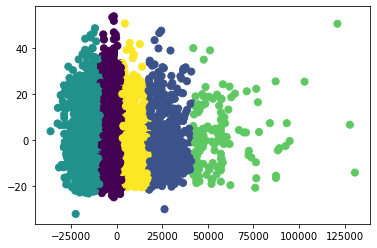

In [109]:
# Back to ML
aggData = np.array(agg_df.drop("city",1))
kmeans = KMeans(n_clusters=3)
kmeans.fit(aggData)

aggPrediction = kmeans.predict(aggData)
# Use PCA to plot it
pca = PCA(n_components=2)
aggOut = pca.fit_transform(aggData)
aggOutput_df = pd.DataFrame(aggOut)
aggOutput_df.columns = ["x","y"]
aggOutput_df["prediction"] = aggPrediction

plt.scatter(aggOutput_df["x"], aggOutput_df["y"], c=aggOutput_df["prediction"], s=50, cmap='viridis')
plt.show()